### make plots for overleaf paper 

In [2]:
pwd

'/home/idies/workspace/Storage/lixl/persistent/LSSTunknowns/tdAnom'

In [1]:
# get the name of all opsim dbs 
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
# load opsim database
dbpath_v1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v1_7 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"  # path to all opsim databases
dbpath_v1_7_1 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"  # path to all opsim databases



In [3]:

# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath_v1_5)  # change to opsim database directory
dblist_all_v1_5 = glob.glob('*.db') 
dblist_all_v1_5.sort()

os.chdir(dbpath_v1_7)  # change to opsim database directory
dblist_all_v1_7 = glob.glob('*.db') 
dblist_all_v1_7.sort()

os.chdir(dbpath_v1_7_1)  # change to opsim database directory
dblist_all_v1_7_1 = glob.glob('*.db') 
dblist_all_v1_7_1.sort()

dblist_all_v1_7_1 = [x.replace('v1.7.1', 'v1.7').replace('v1.7', 'v1.7.1') for x in dblist_all_v1_7_1]

os.chdir(workpath) # change back to work directory




In [4]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"



In [5]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']

cols_diff_db = ['db', 'ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [6]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [7]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("10yrs", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new




In [8]:

def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap




In [14]:

def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", 
                    dbtoarrow=[], invertx=False, ytickpos='left', title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_max_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_max_family, on='family', how='left', suffixes=['', '_fmax'],)
    
    # get the mean FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).mean()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'])
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmax', 'total_fmean', 'total' ], ascending=[True, True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
        
    if invertx:
        ax.invert_xaxis()
        #ax.yaxis.tick_right()
        plt.legend(loc='lower left', frameon=True)
    
    ax.yaxis.tick_right() if ytickpos=='right' else ax.yaxis.tick_left()

    # add arrow   
    if dbtoarrow:
        for d in dbtoarrow:
            idx = np.where(df_.index==d)
            if not invertx:
                xin,xfin= -0.52, -0.62
            else:
                xin,xfin= 1.52, 1.62
            ax.annotate('', xy=(xin,idx[0]/len(df_.index)+0.005), 
                            xytext=(xfin, idx[0]/len(df_.index)+0.005), 
                            xycoords='axes fraction', 
                            arrowprops=dict( facecolor='black', shrink=0.05))
    
    # modify labels
    for tl in ax.get_yticklabels():
        txt = tl.get_text()
        if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
            tl.set_backgroundcolor("#E5E7E9")
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    
        #tl.set_text(txt)
    #

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    return ax
        

In [9]:
def plot_barh_v2(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""
    from matplotlib.patches import Patch

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    #plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    #for i, patch in enumerate(ax.patches):
    #    if i in [10,20]:
    #        patch.set_color('black')
    
    # modify labels
    #for tl in ax.get_yticklabels():
    #    txt = tl.get_text()
    #    if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_backgroundcolor("#E5E7E9")
    #    if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_fontweight('bold') 
            
    #    #tl.set_text(txt)
    #cmap = plt.cm.get_cmap('plasma')
    #colors = [cmap(i) for i in np.linspace(0, 1, 4)][:4]
    colors = [(0.050383, 0.029803, 0.527975, 0.65),
              (0.610667, 0.090204, 0.619951, 0.65),
              ( 0.928329, 0.472975, 0.326067, 0.65),
              (0.940015, 0.975158, 0.131326, 0.65)]
    
    color1 = 'steelblue'
    color2 = colors[2]
    for i, (patch, tl) in enumerate( zip(ax.patches[:160], ax.get_yticklabels() ) ):
        txt = tl.get_text()
        for pi in [i+160*j for j in range(5)]:
            p = ax.patches[pi]
            if 'v1.7' in txt:
                p.set_color(color1)   
            else:
                p.set_color(color2)
                
            p.set_linewidth(0.1)
            p.set_edgecolor('black')
                        
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    # create legend
    legend_elements = [ Patch(facecolor=color1, edgecolor='k',
                         label='OpSim v1.7'),
                        Patch(facecolor=color2, edgecolor='k',
                         label='OpSim v1.5')]
              
    ax.legend(handles=legend_elements, loc='lower right', facecolor='w', frameon=True)

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    
    return ax



### barh_tgaps_wfd

In [25]:
#fomcsv = './data_v1_5/df_tgapsFoM_wfd.csv'
fomcsv = './data/df_tgaps_log_v1.5_WFD.csv'


dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=0)



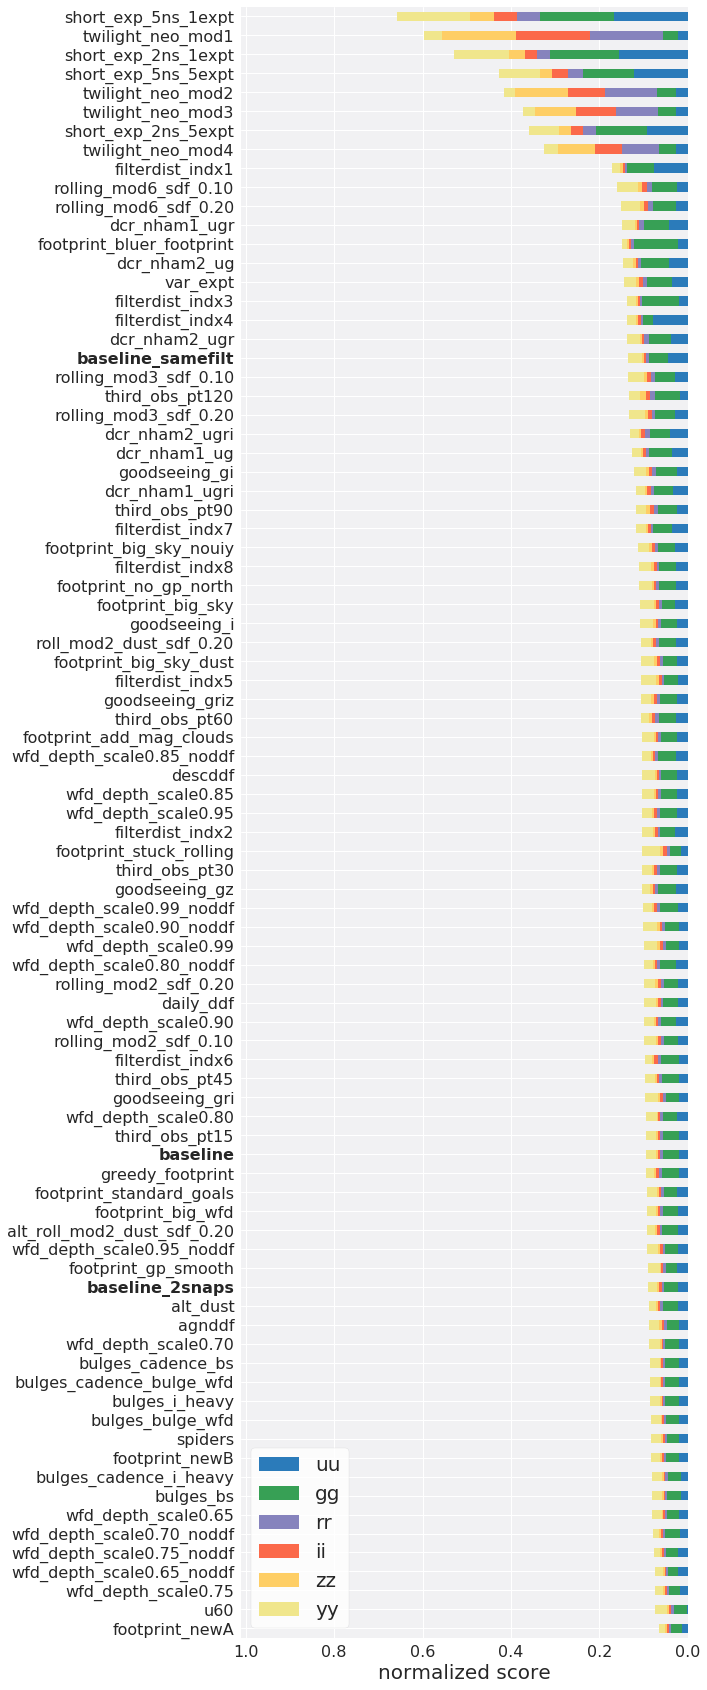

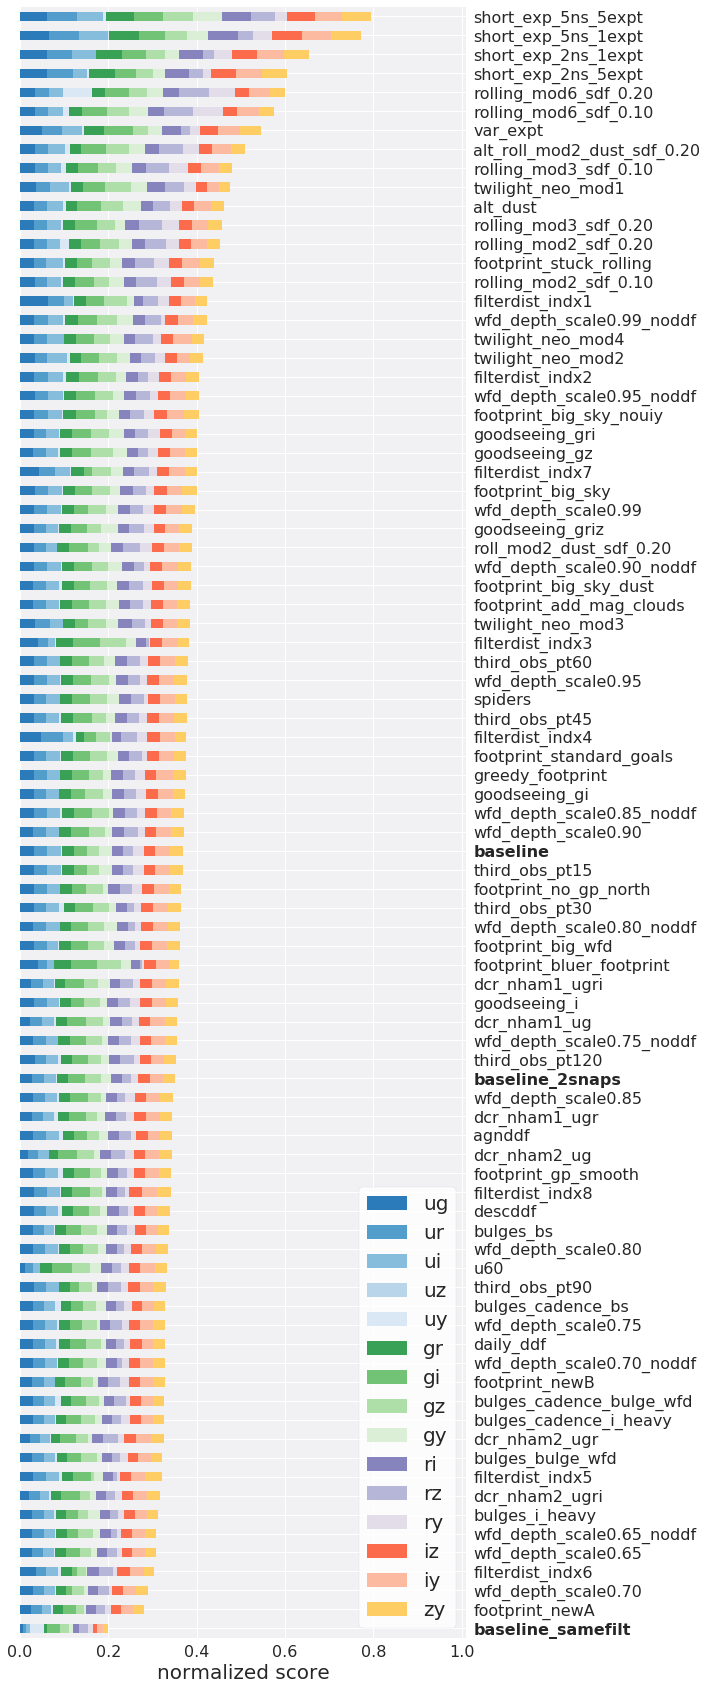

In [26]:
#plot_barh_v2(df_norm, colon=cols_same, byfamily=False, savefig='figures/barh_tgaps_same_wfd.pdf', colormap=get_mycmap(pairs='same')) 
#plot_barh_v2(df_norm, colon=cols_diff, byfamily=False, savefig='figures/barh_tgaps_diff_wfd.pdf', colormap=get_mycmap(pairs='diff') ) 

ax = plot_barh(df_norm, colon=cols_same, invertx=True, byfamily=False, savefig='figures/barh_tgaps_same_wfd_invertx.pdf', colormap=get_mycmap(pairs='same')) 
ax = plot_barh(df_norm, colon=cols_diff, invertx=False, ytickpos='right', byfamily=False, savefig='figures/barh_tgaps_diff_log_wfd_invertx.pdf', colormap=get_mycmap(pairs='diff')) 




### detph

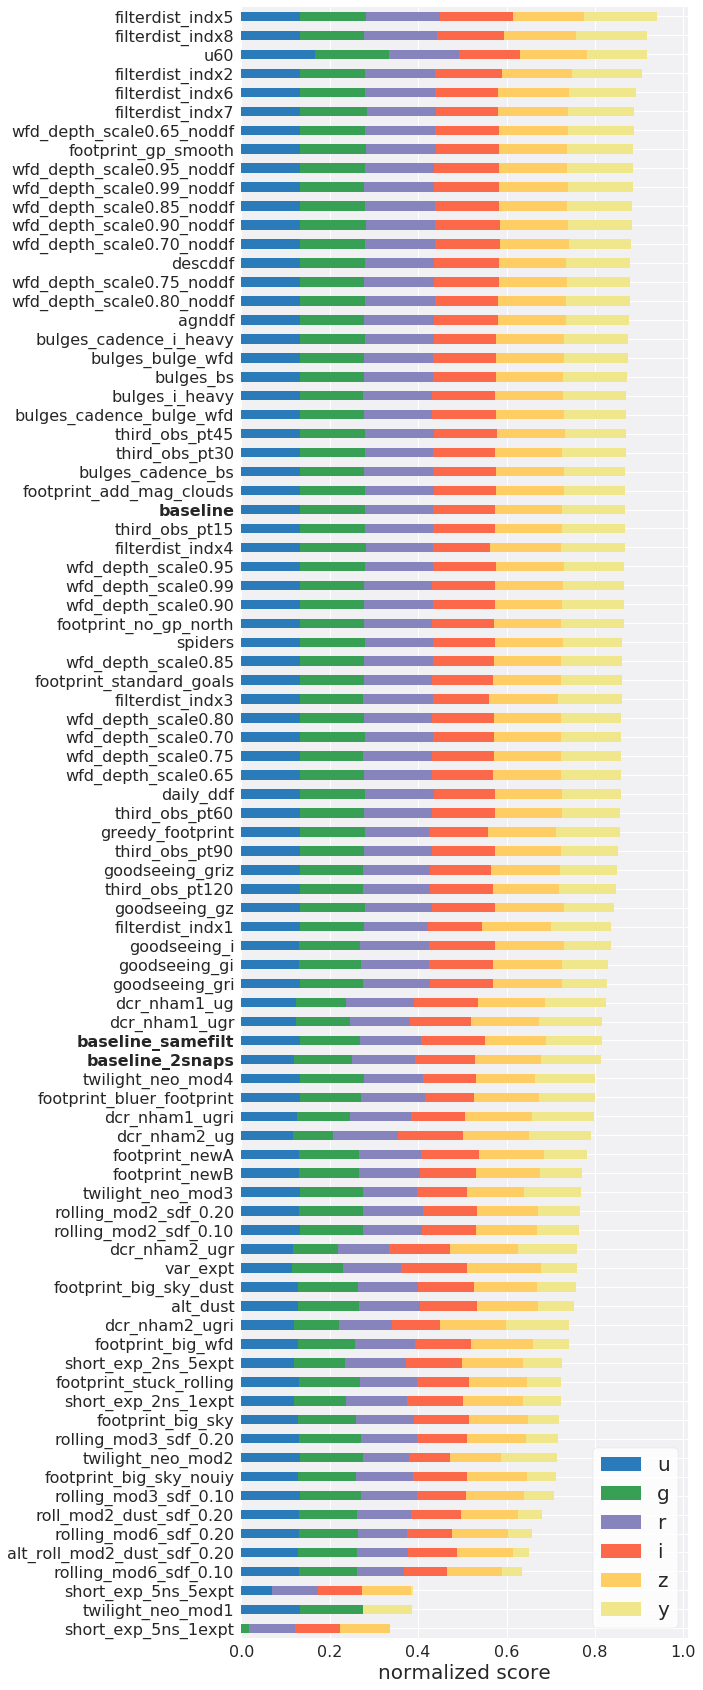

In [27]:
#fomcsv = './data_v1_5/df_tgapsFoM_wfd.csv'
fomcsv = './data/df_depth_v1.5_WFD.csv'


dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=filters, mode=1)

ax = plot_barh(df_norm, colon=filters, invertx=False, byfamily=False, savefig='figures/barh_depth_wfd.pdf', colormap=get_mycmap(pairs='same')) 



### barh_nfields

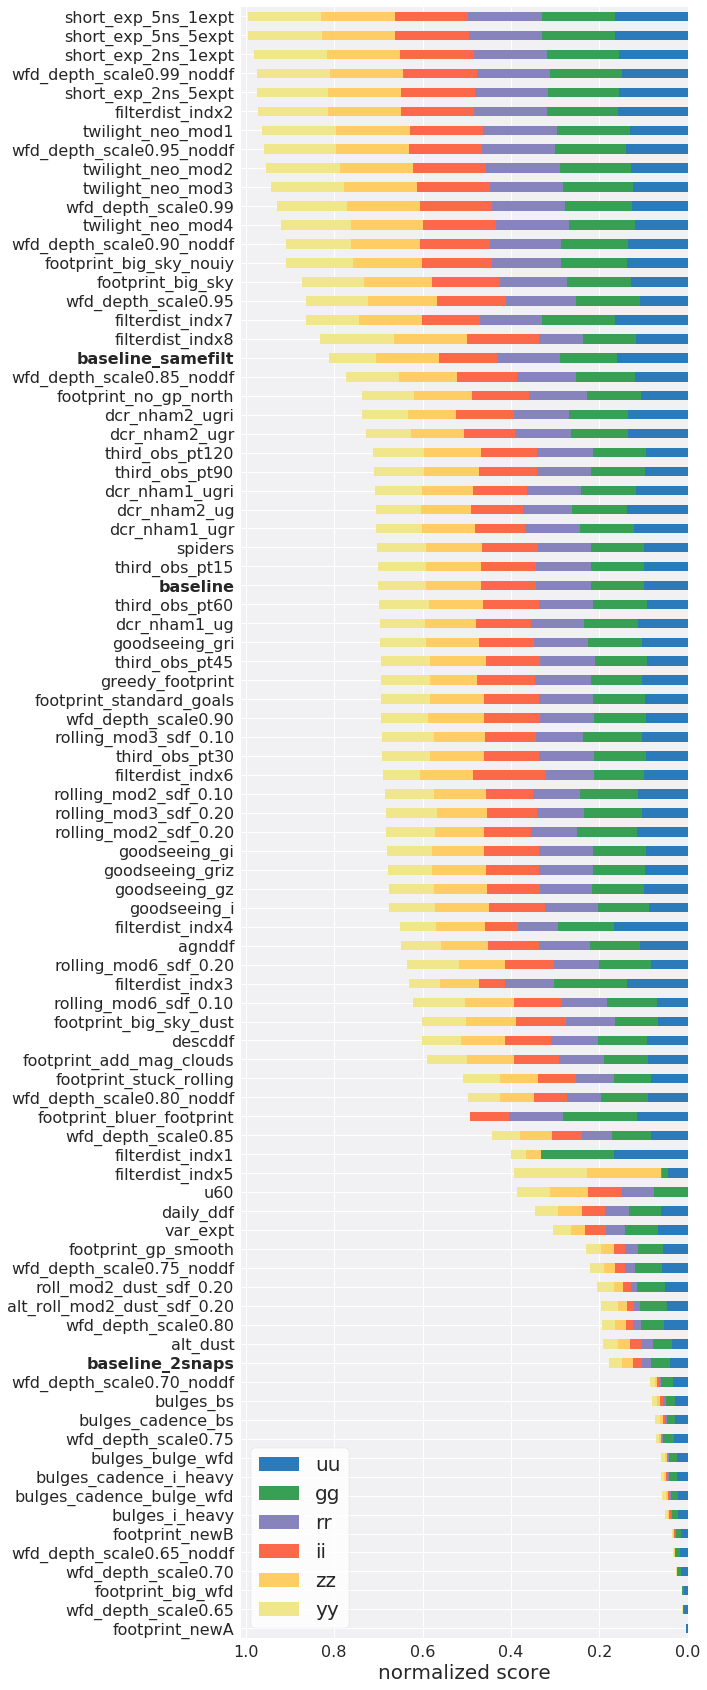

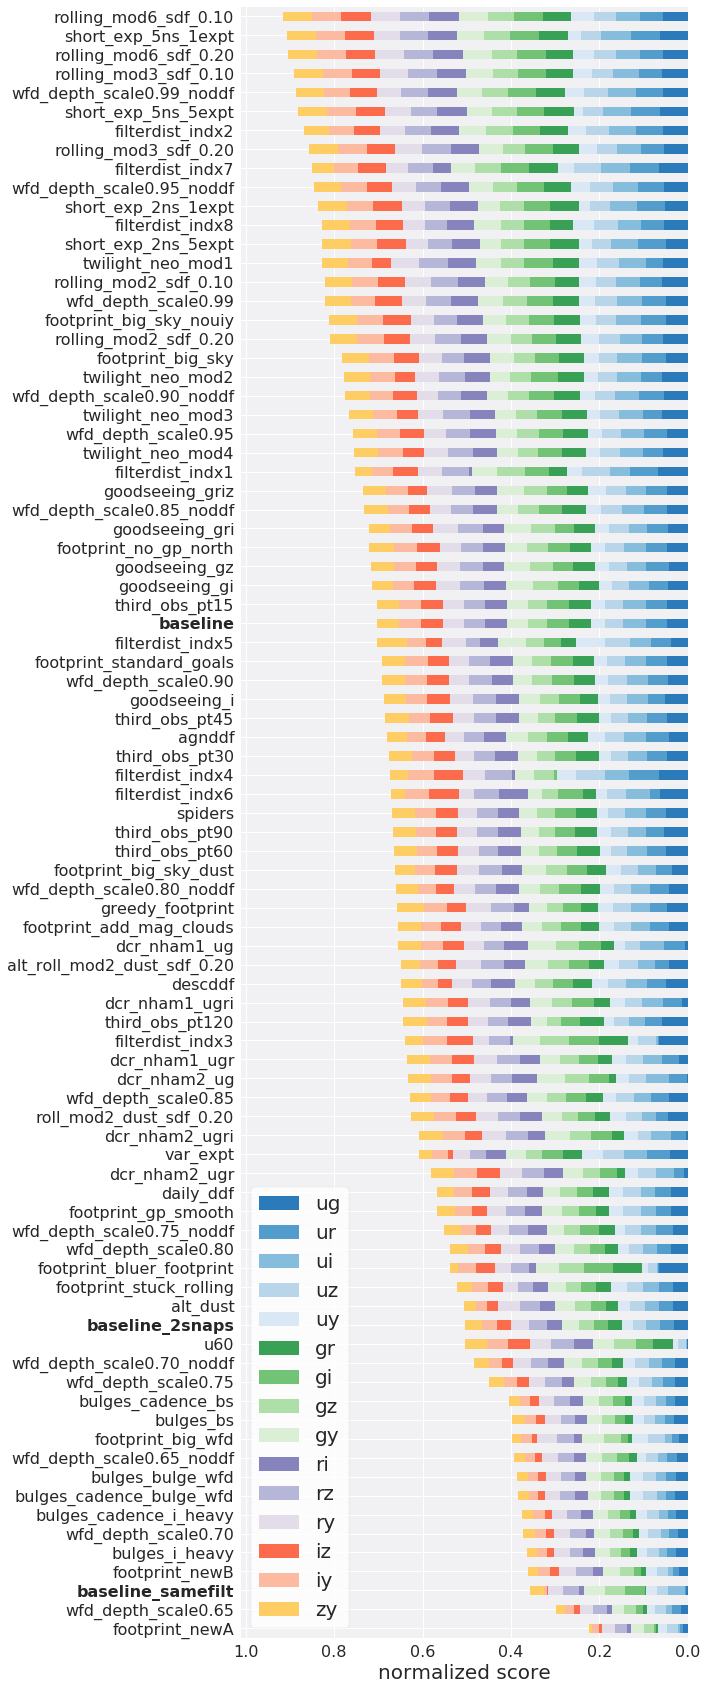

In [28]:
fomcsv = './data/df_Nfields_2d_v1.5_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=0)


ax = plot_barh(df_norm, colon=cols_same, invertx=True, byfamily=False, savefig='figures/barh_nfields_same_wfd_invertx.pdf', colormap=get_mycmap(pairs='same')) 
ax = plot_barh(df_norm, colon=cols_diff, invertx=True, byfamily=False, savefig='figures/barh_nfields_diff_wfd_invertx.pdf', colormap=get_mycmap(pairs='diff')) 



### barh_nstars

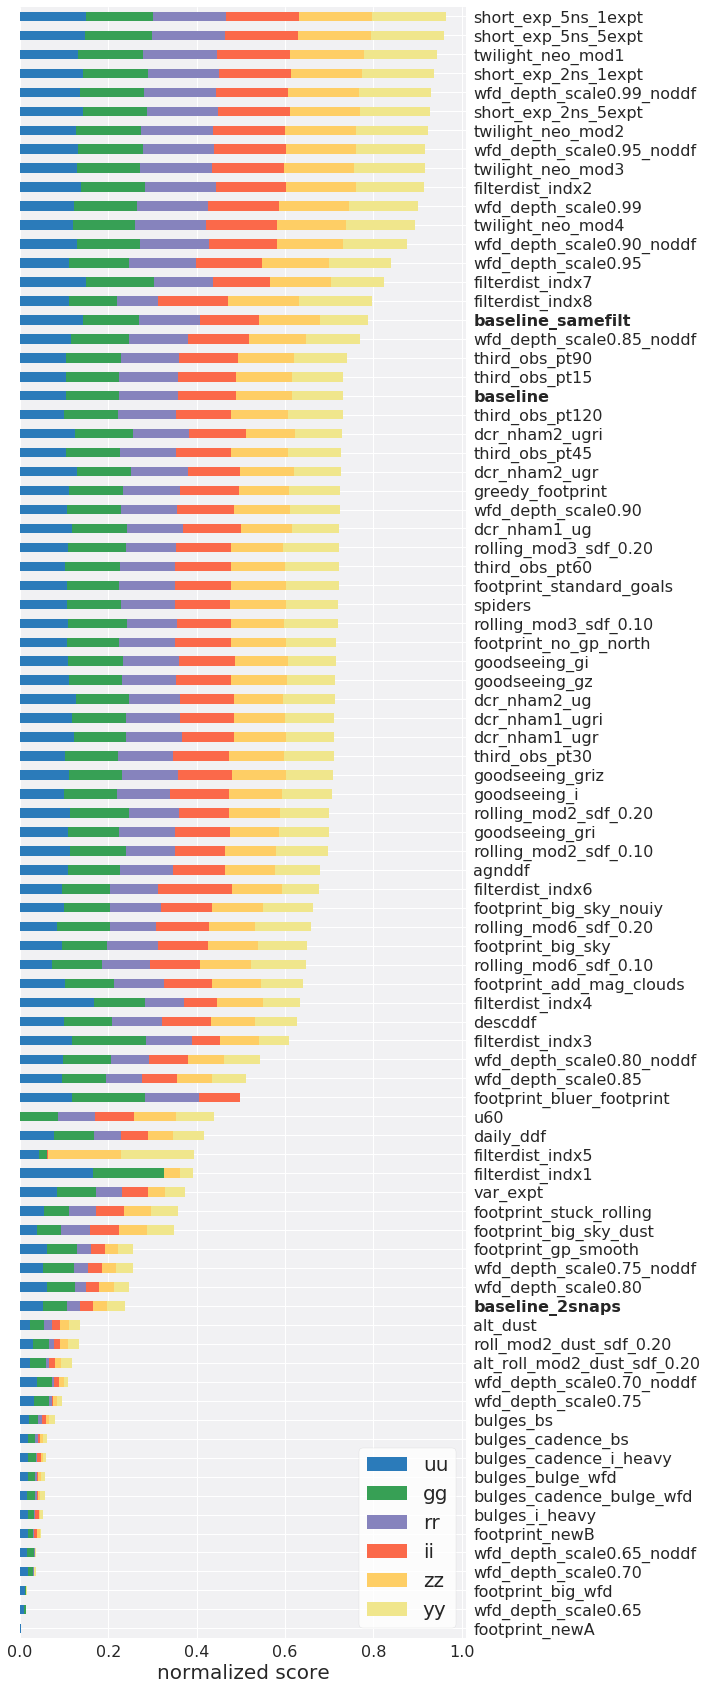

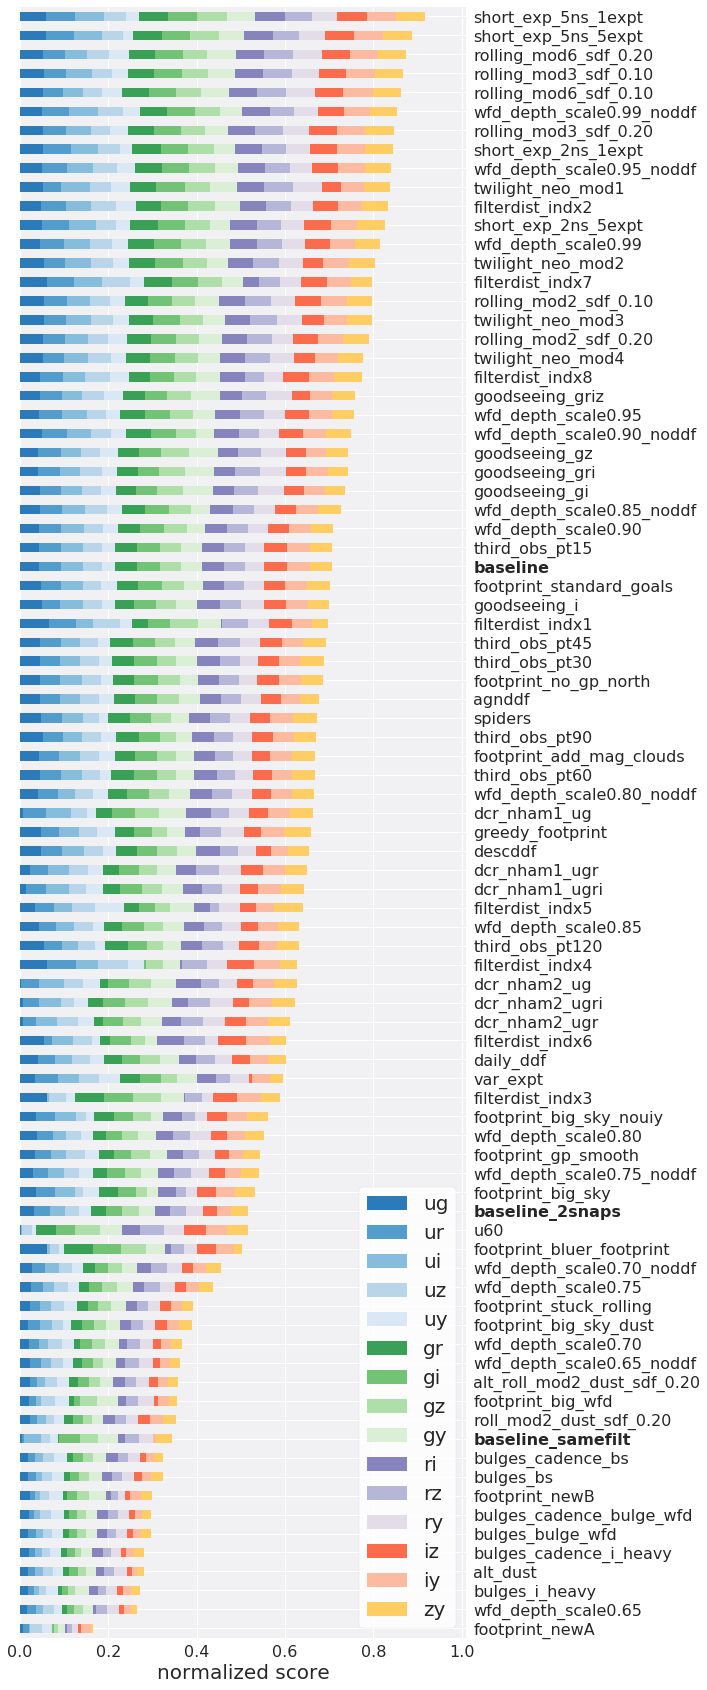

In [29]:
fomcsv = './data/df_Nstars_2d_v1.5_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=cols_all, mode=0)


ax = plot_barh(df_norm, colon=cols_same, invertx=False, ytickpos='right', byfamily=False, savefig='figures/barh_nstars_same_wfd_invertx.pdf', colormap=get_mycmap(pairs='same')) 
ax = plot_barh(df_norm, colon=cols_diff, invertx=False, ytickpos='right', byfamily=False, savefig='figures/barh_nstars_diff_wfd_invertx.pdf', colormap=get_mycmap(pairs='diff')) 




### barh_family_wfd, bar_family_all

In [10]:
FoMvars = ['flux change','color', 'depth', 'footprint', 'star count',]


In [11]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



In [12]:
import matplotlib.colors as mcolors
colors = plt.cm.Set1( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



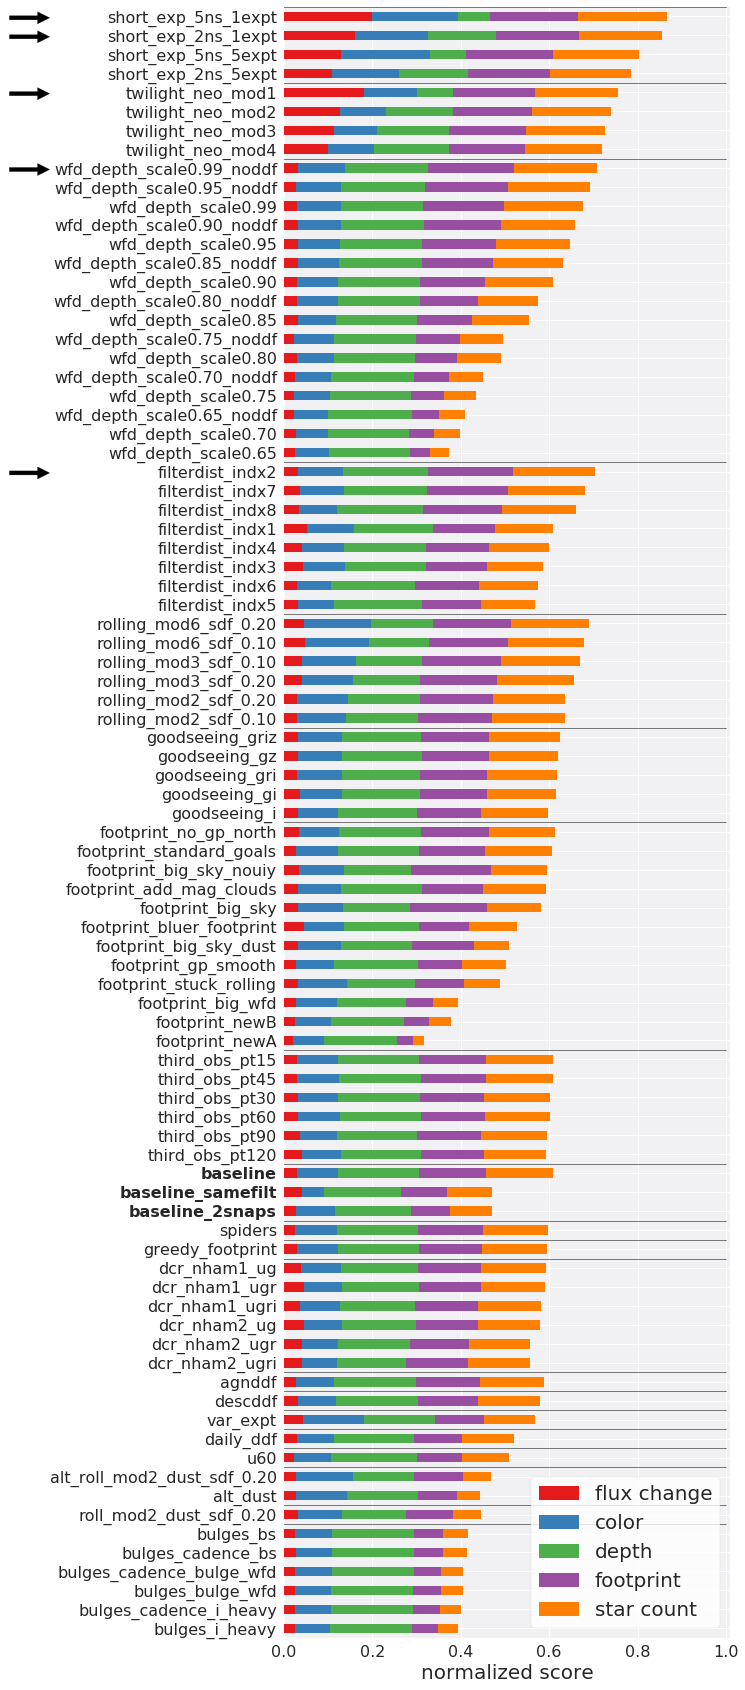

In [17]:
fomcsv = './data/df_radar_log_v1.5_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)

dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_wfd.pdf', colormap=mymap) 



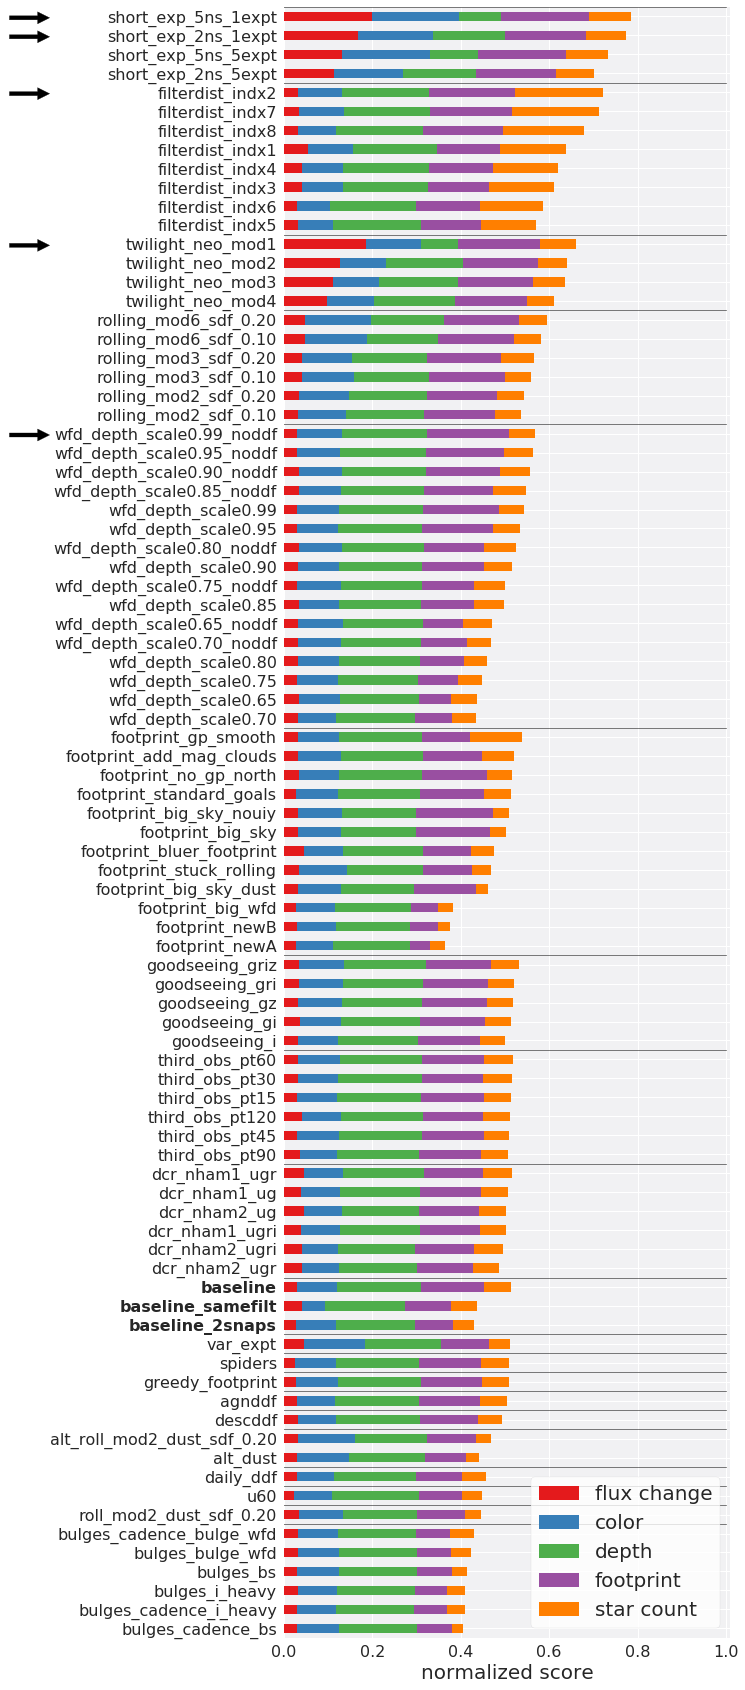

In [18]:
fomcsv = './data/df_radar_log_v1.5_ALL.csv'

dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)

#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_all.pdf', colormap=mymap) 



### barh_family_minisurvey

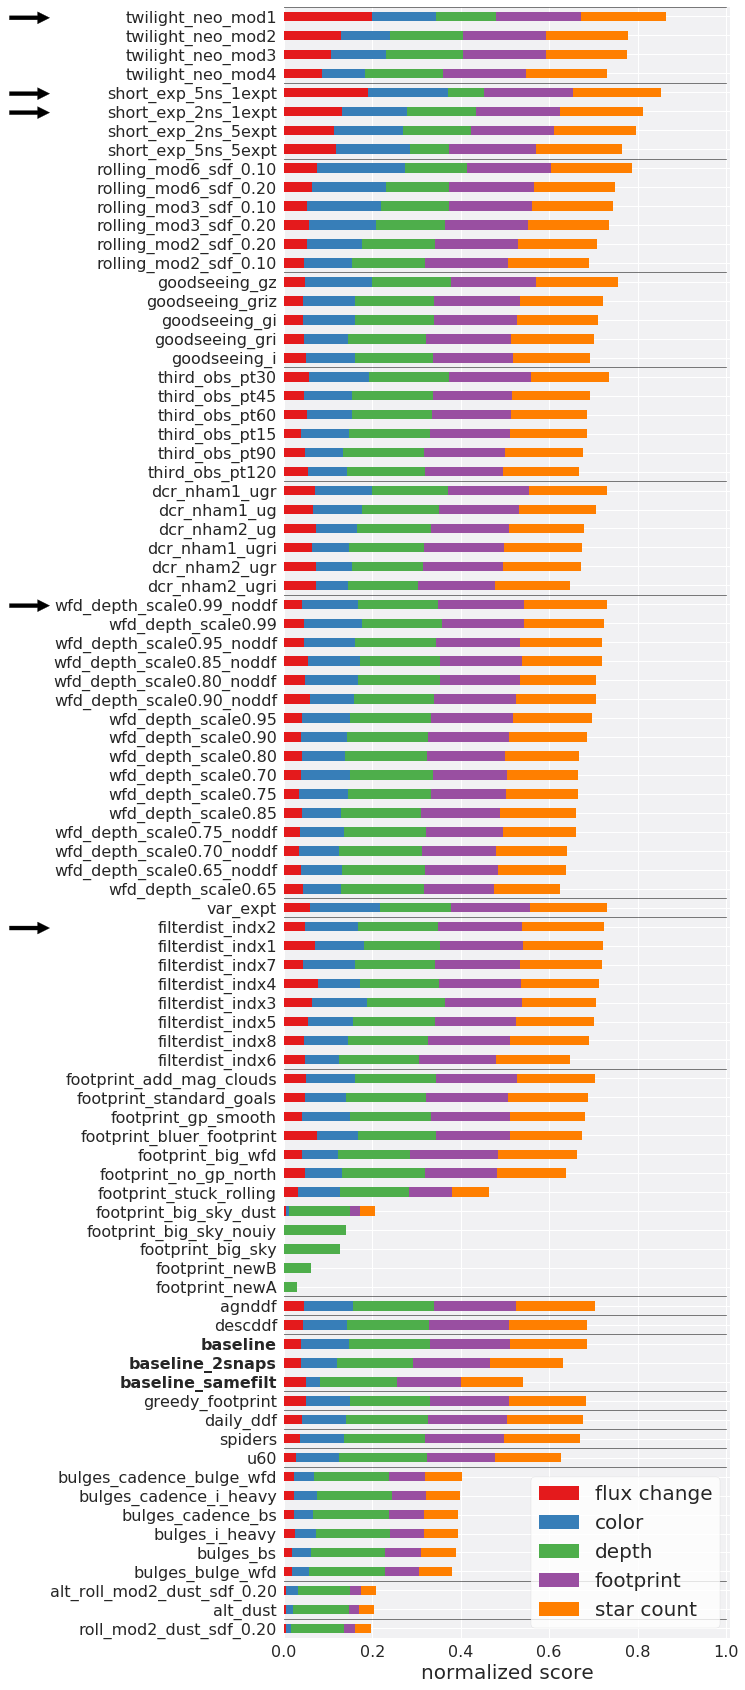

In [19]:
fomcsv = './data/df_radar_log_v1.5_GP_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)


#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_GP_inwfd.pdf', colormap=mymap) 




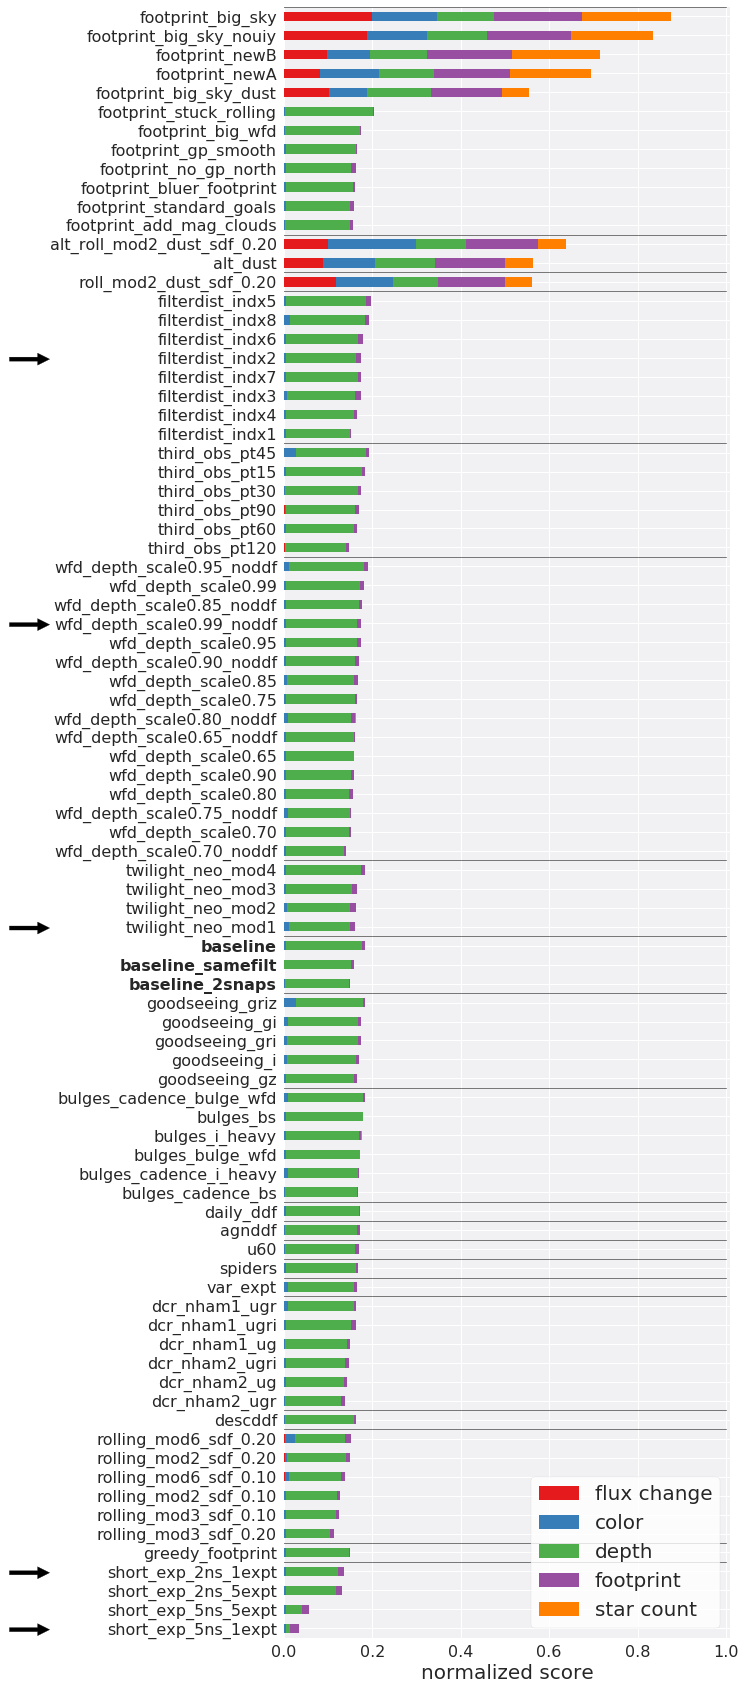

In [20]:
fomcsv = './data/df_radar_log_v1.5_LMC_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)

#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_LMC_inwfd.pdf', colormap=mymap) 



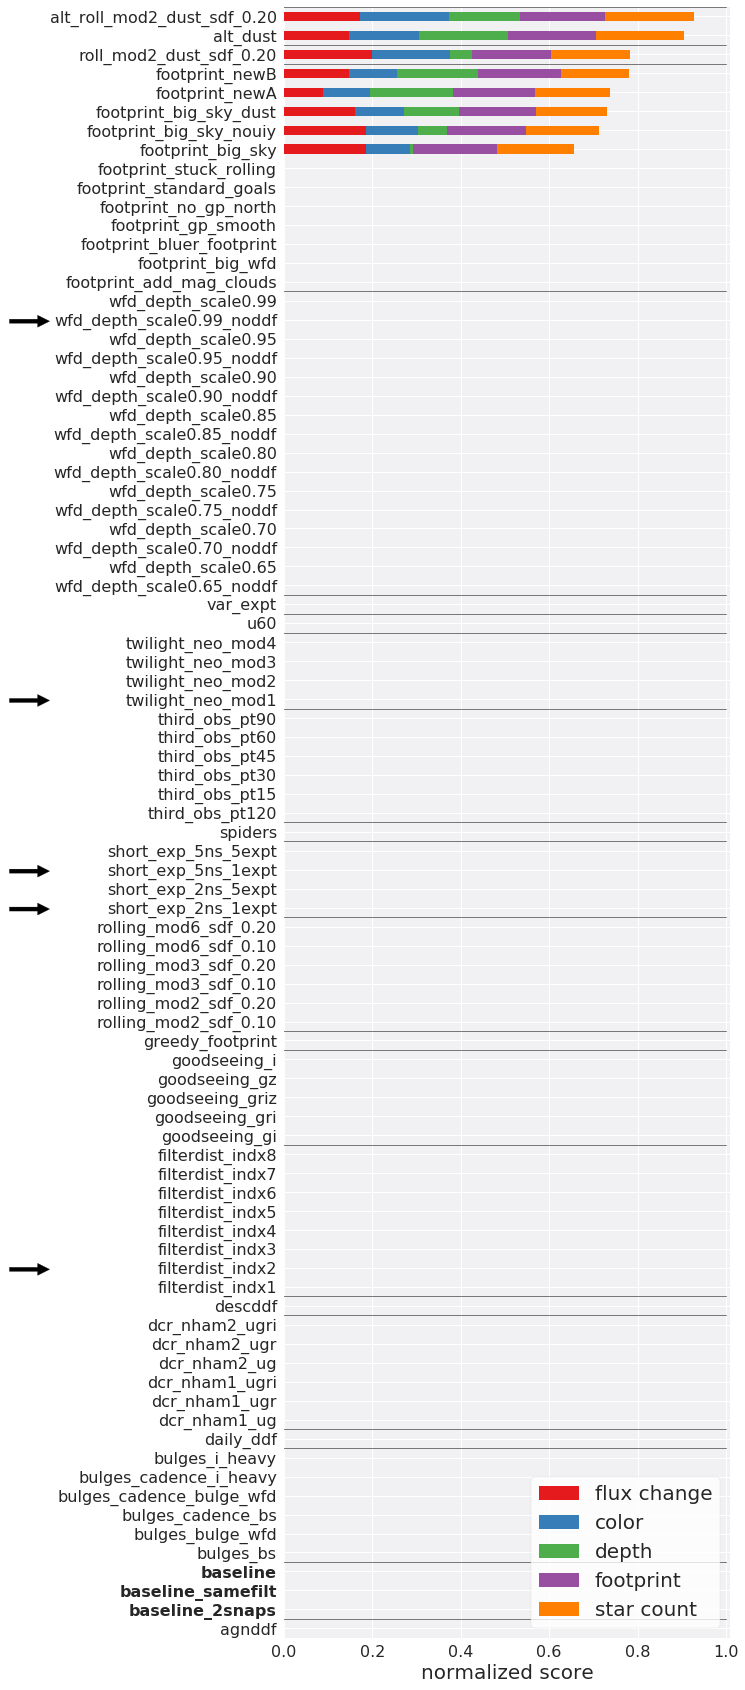

In [22]:
fomcsv = './data/df_radar_log_v1.5_SMC_WFD.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)


#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_SMC_inwfd.pdf', colormap=mymap) 




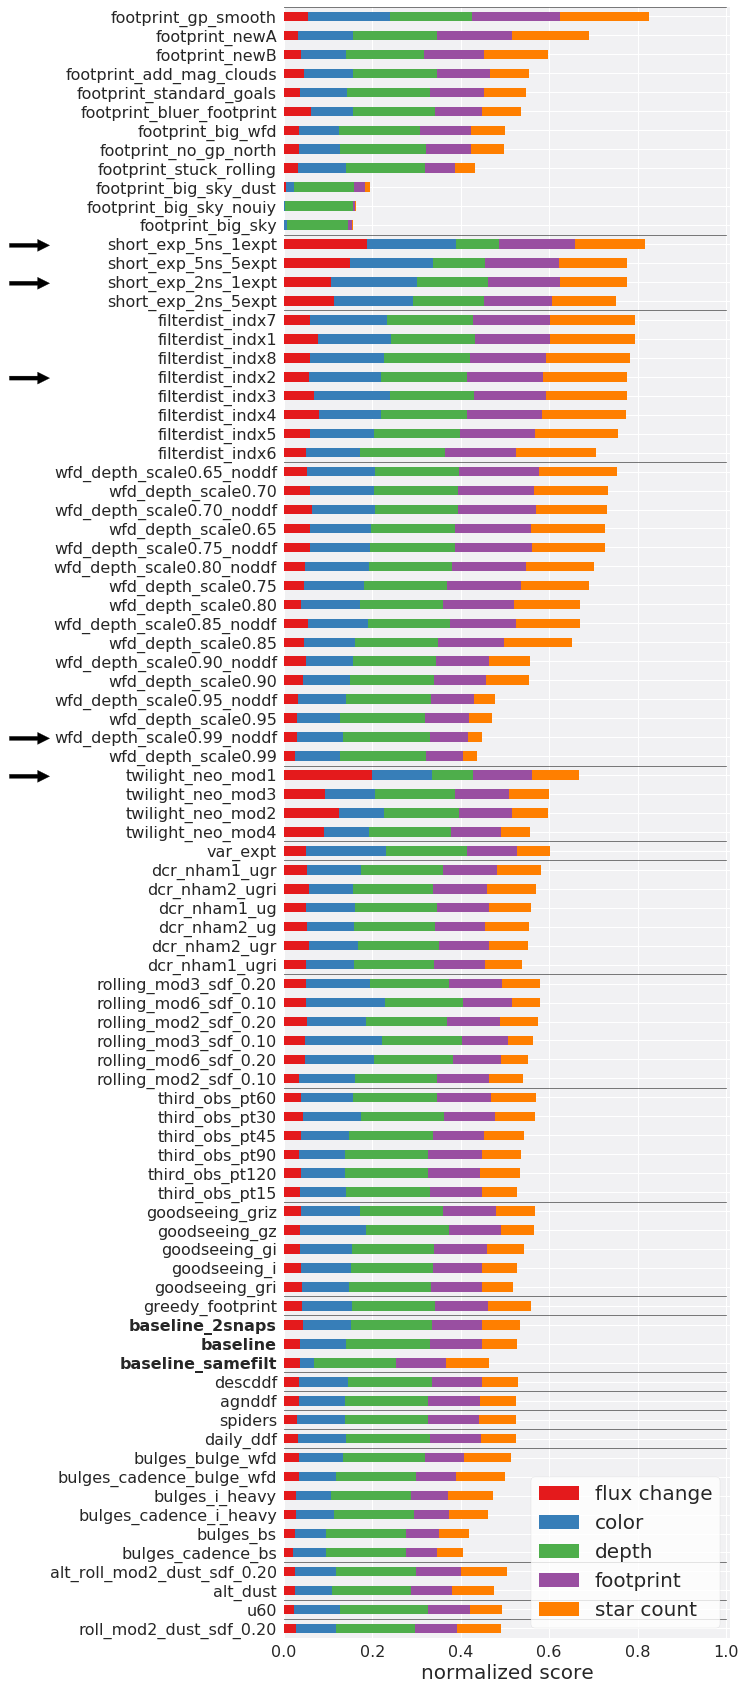

In [23]:
fomcsv = './data/df_radar_log_v1.5_GP_ALL.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)


#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_GP_allsky.pdf', colormap=mymap) 


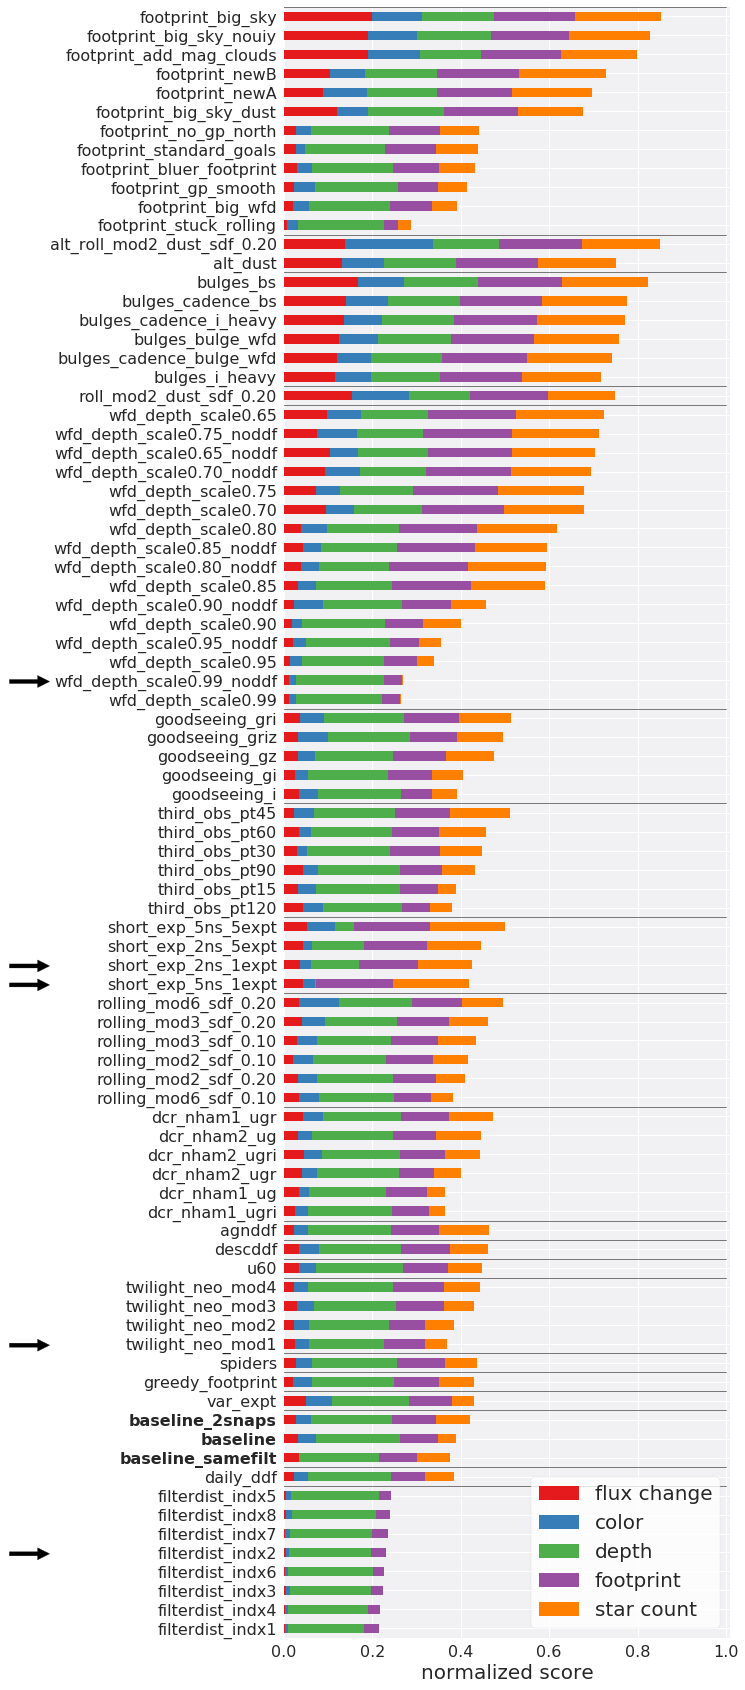

In [24]:
fomcsv = './data/df_radar_log_v1.5_LMC_ALL.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)

#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_LMC_allsky.pdf', colormap=mymap) 



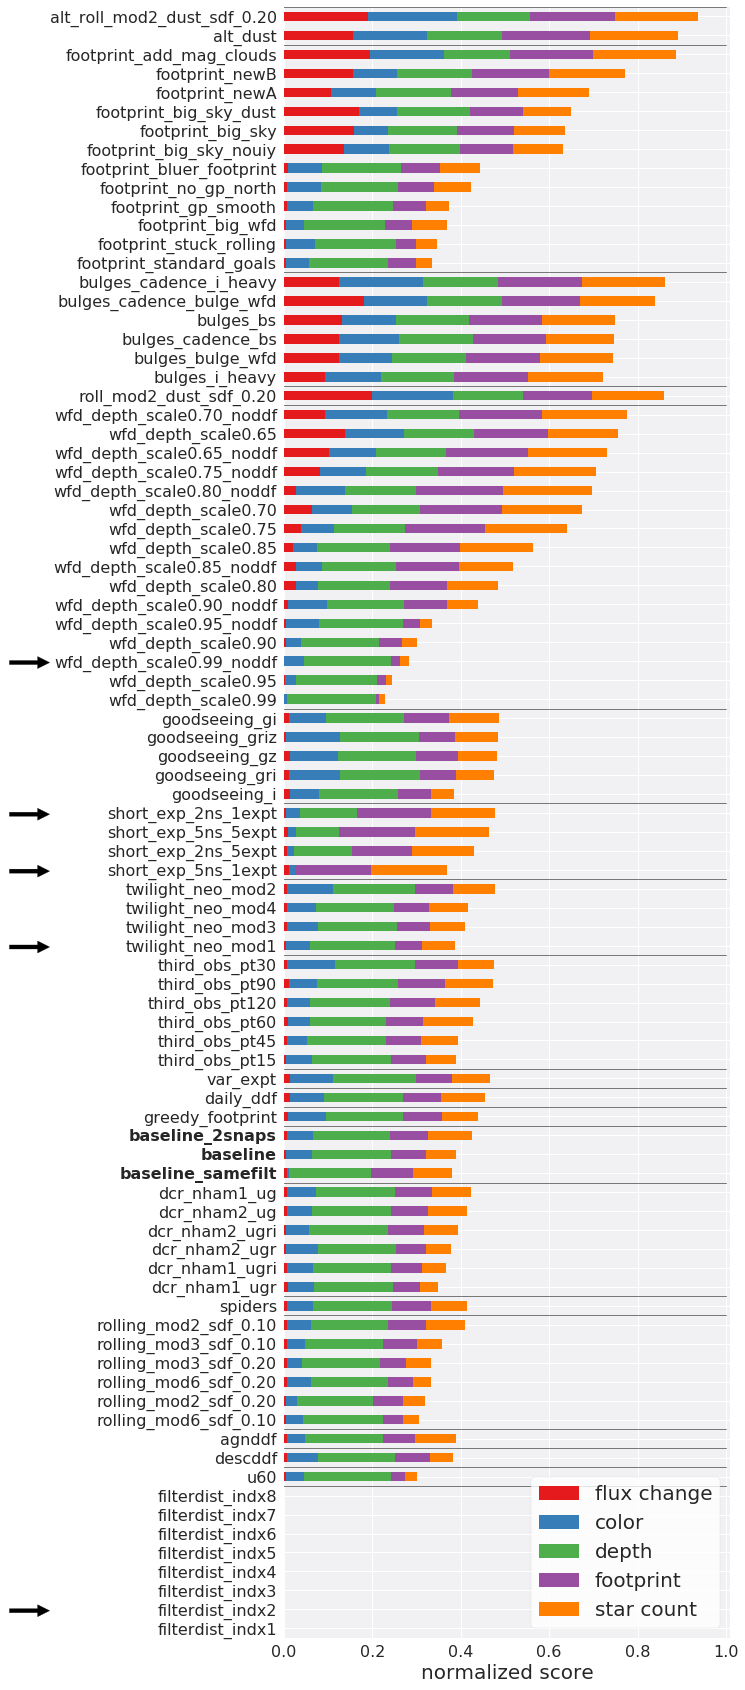

In [25]:
fomcsv = './data/df_radar_log_v1.5_SMC_ALL.csv'
dblist_all = dblist_all_v1_5
df_norm = get_df_norm(fomcsv = fomcsv, cols=FoMvars, mode=0)


#ax = plot_barh(df_norm, colon=FoMvars, invertx=False, ytickpos='left', byfamily=True, savefig='figures/barh_family_all.pdf', colormap=mymap) 
dbtoarrow = ['short_exp_5ns_1expt', 'short_exp_2ns_1expt', 'twilight_neo_mod1', 
             'wfd_depth_scale0.99_noddf', 'filterdist_indx2']  #'short_exp_5ns_1expt'

ax = plot_barh(df_norm, colon=FoMvars, dbtoarrow=dbtoarrow,
               invertx=False, ytickpos='left', byfamily=True, 
               savefig='figures/barh_family_SMC_allsky.pdf', colormap=mymap) 




### barh_family_wfd_v1_5_v1_7_v1_7_1

In [26]:
def plot_barh_v3(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""
    from matplotlib.patches import Patch

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    #plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    #for i, patch in enumerate(ax.patches):
    #    if i in [10,20]:
    #        patch.set_color('black')
    
    # modify labels
    #for tl in ax.get_yticklabels():
    #    txt = tl.get_text()
    #    if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_backgroundcolor("#E5E7E9")
    #    if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_fontweight('bold') 
            
    #    #tl.set_text(txt)
    #cmap = plt.cm.get_cmap('plasma')
    #colors = [cmap(i) for i in np.linspace(0, 1, 4)][:4]
    colors = [(0.050383, 0.029803, 0.527975, 0.65),
              (0.610667, 0.090204, 0.619951, 0.65),
              ( 0.928329, 0.472975, 0.326067, 0.65),
              (0.940015, 0.975158, 0.131326, 0.65)]
    
    color0 = 'indianred'
    color1 = colors[2]
    color2 = 'steelblue'
    yticklabels = []
    for i, (patch, tl) in enumerate( zip(ax.patches[:170], ax.get_yticklabels() ) ):
        txt = tl.get_text()
        for pi in [i+170*j for j in range(5)]:
            p = ax.patches[pi]
             
            if 'v1.7.1' in txt:
                p.set_color(color0)
                yticklabels.append( txt.replace('_v1.7.1', '').replace('v1.7.1', '') )
            
              
            elif 'v1.7' in txt:
                p.set_color(color1) 
                yticklabels.append( txt.replace('_v1.7', '').replace('v1.7', '') )

            else:
                p.set_color(color2)
                yticklabels.append(txt)
                
            p.set_linewidth(0.1)
            p.set_edgecolor('black')
                        
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    ax.set_yticklabels(yticklabels[0:170*5:5])
    
    # create legend
    legend_elements = [ Patch(facecolor=color0, edgecolor='k',
                         label='OpSim v1.7.1'),
                        Patch(facecolor=color1, edgecolor='k',
                         label='OpSim v1.7'),
                        Patch(facecolor=color2, edgecolor='k',
                         label='OpSim v1.5')]
              
    ax.legend(handles=legend_elements, loc='lower right', fontsize=40, facecolor='w', frameon=True)

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    
    return ax



In [28]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

FoMvars = ['flux change','color', 'depth', 'footprint', 'star count',]


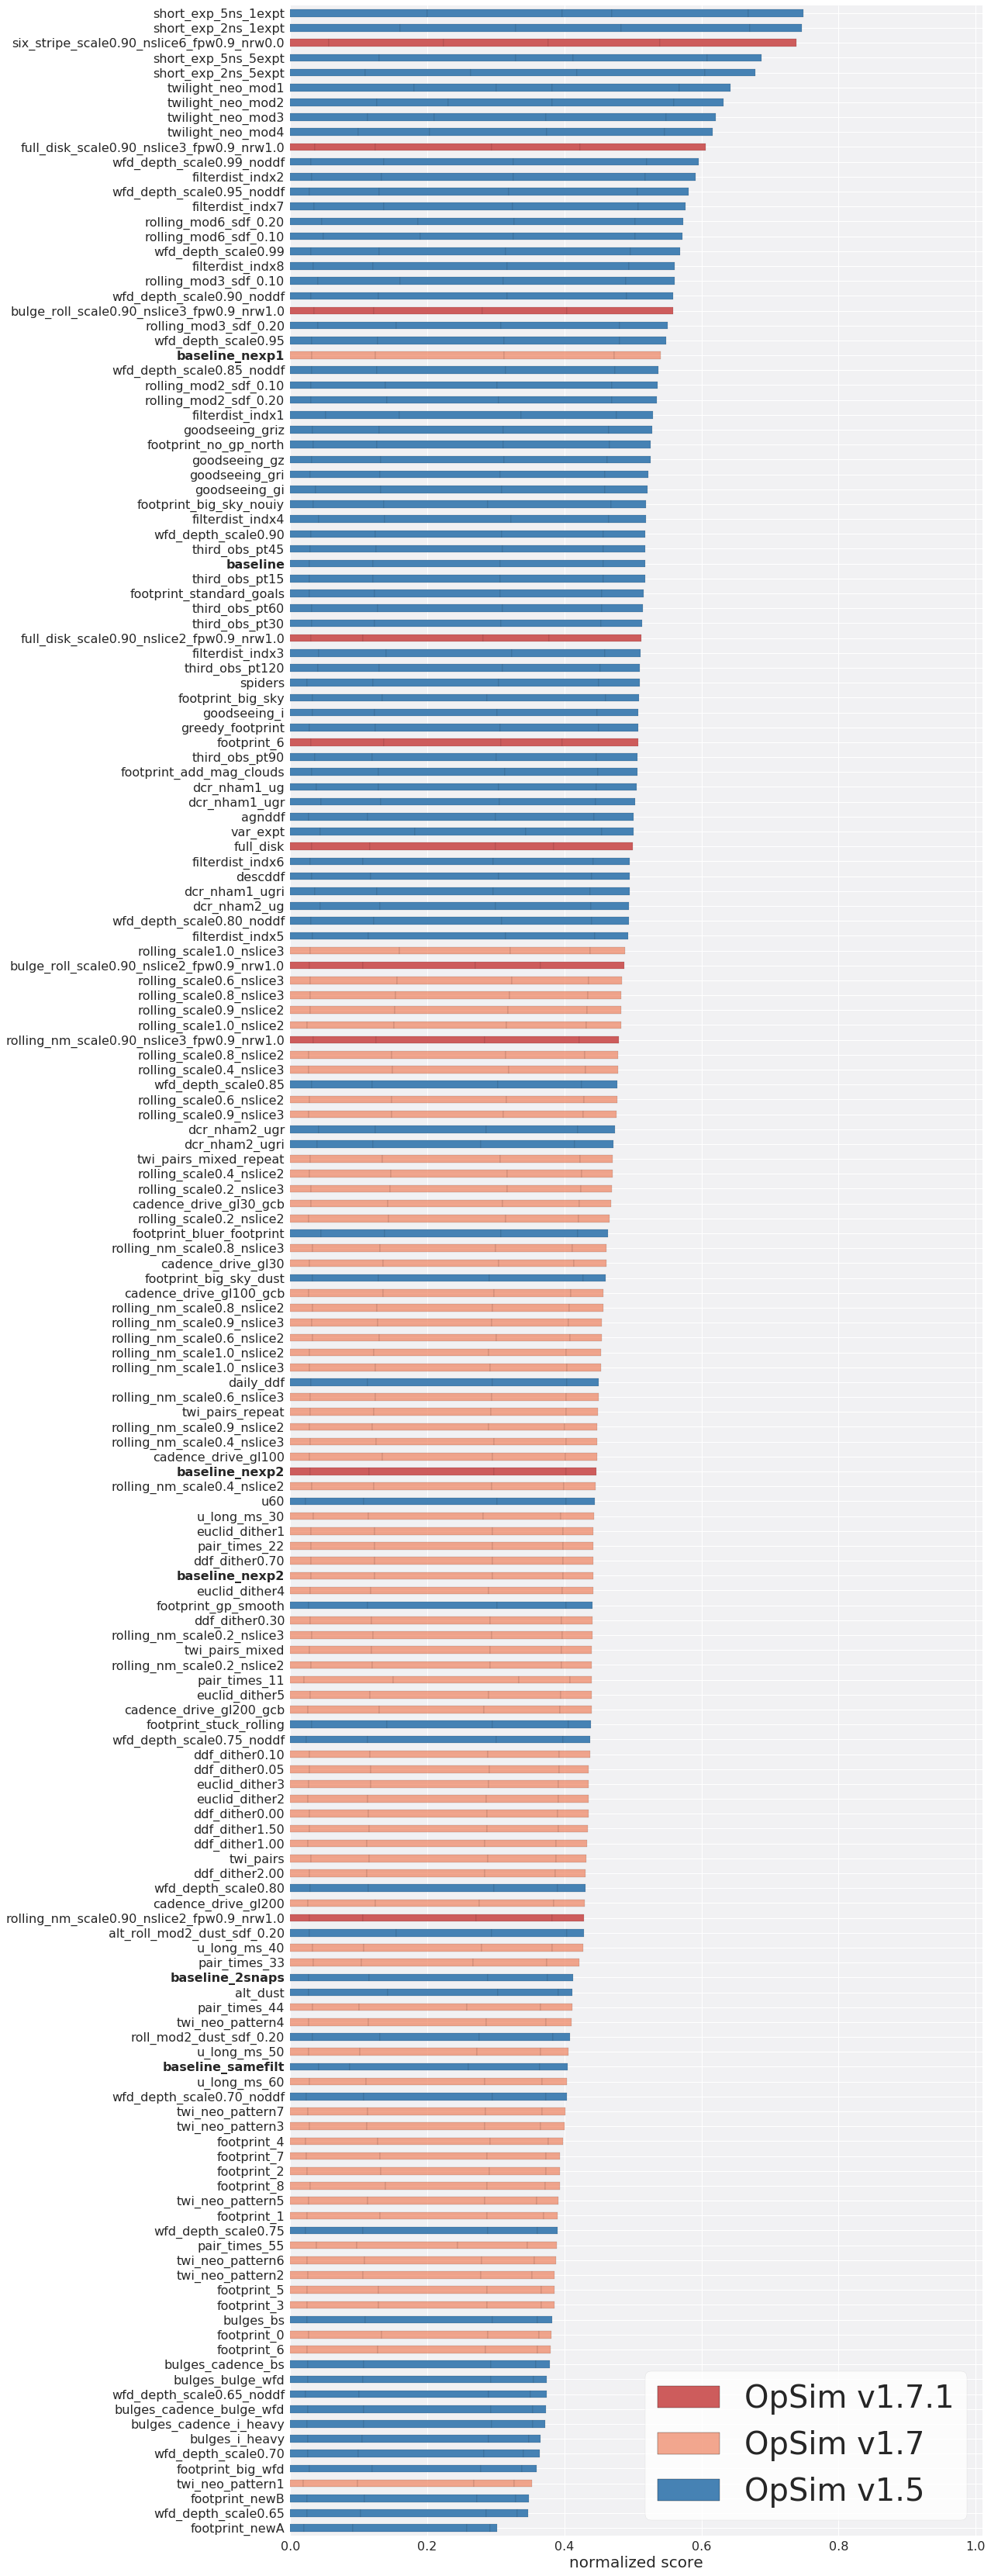

In [37]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_WFD.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv, cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_wfd_v1_5_v1_7.pdf', colormap=mymap ) 



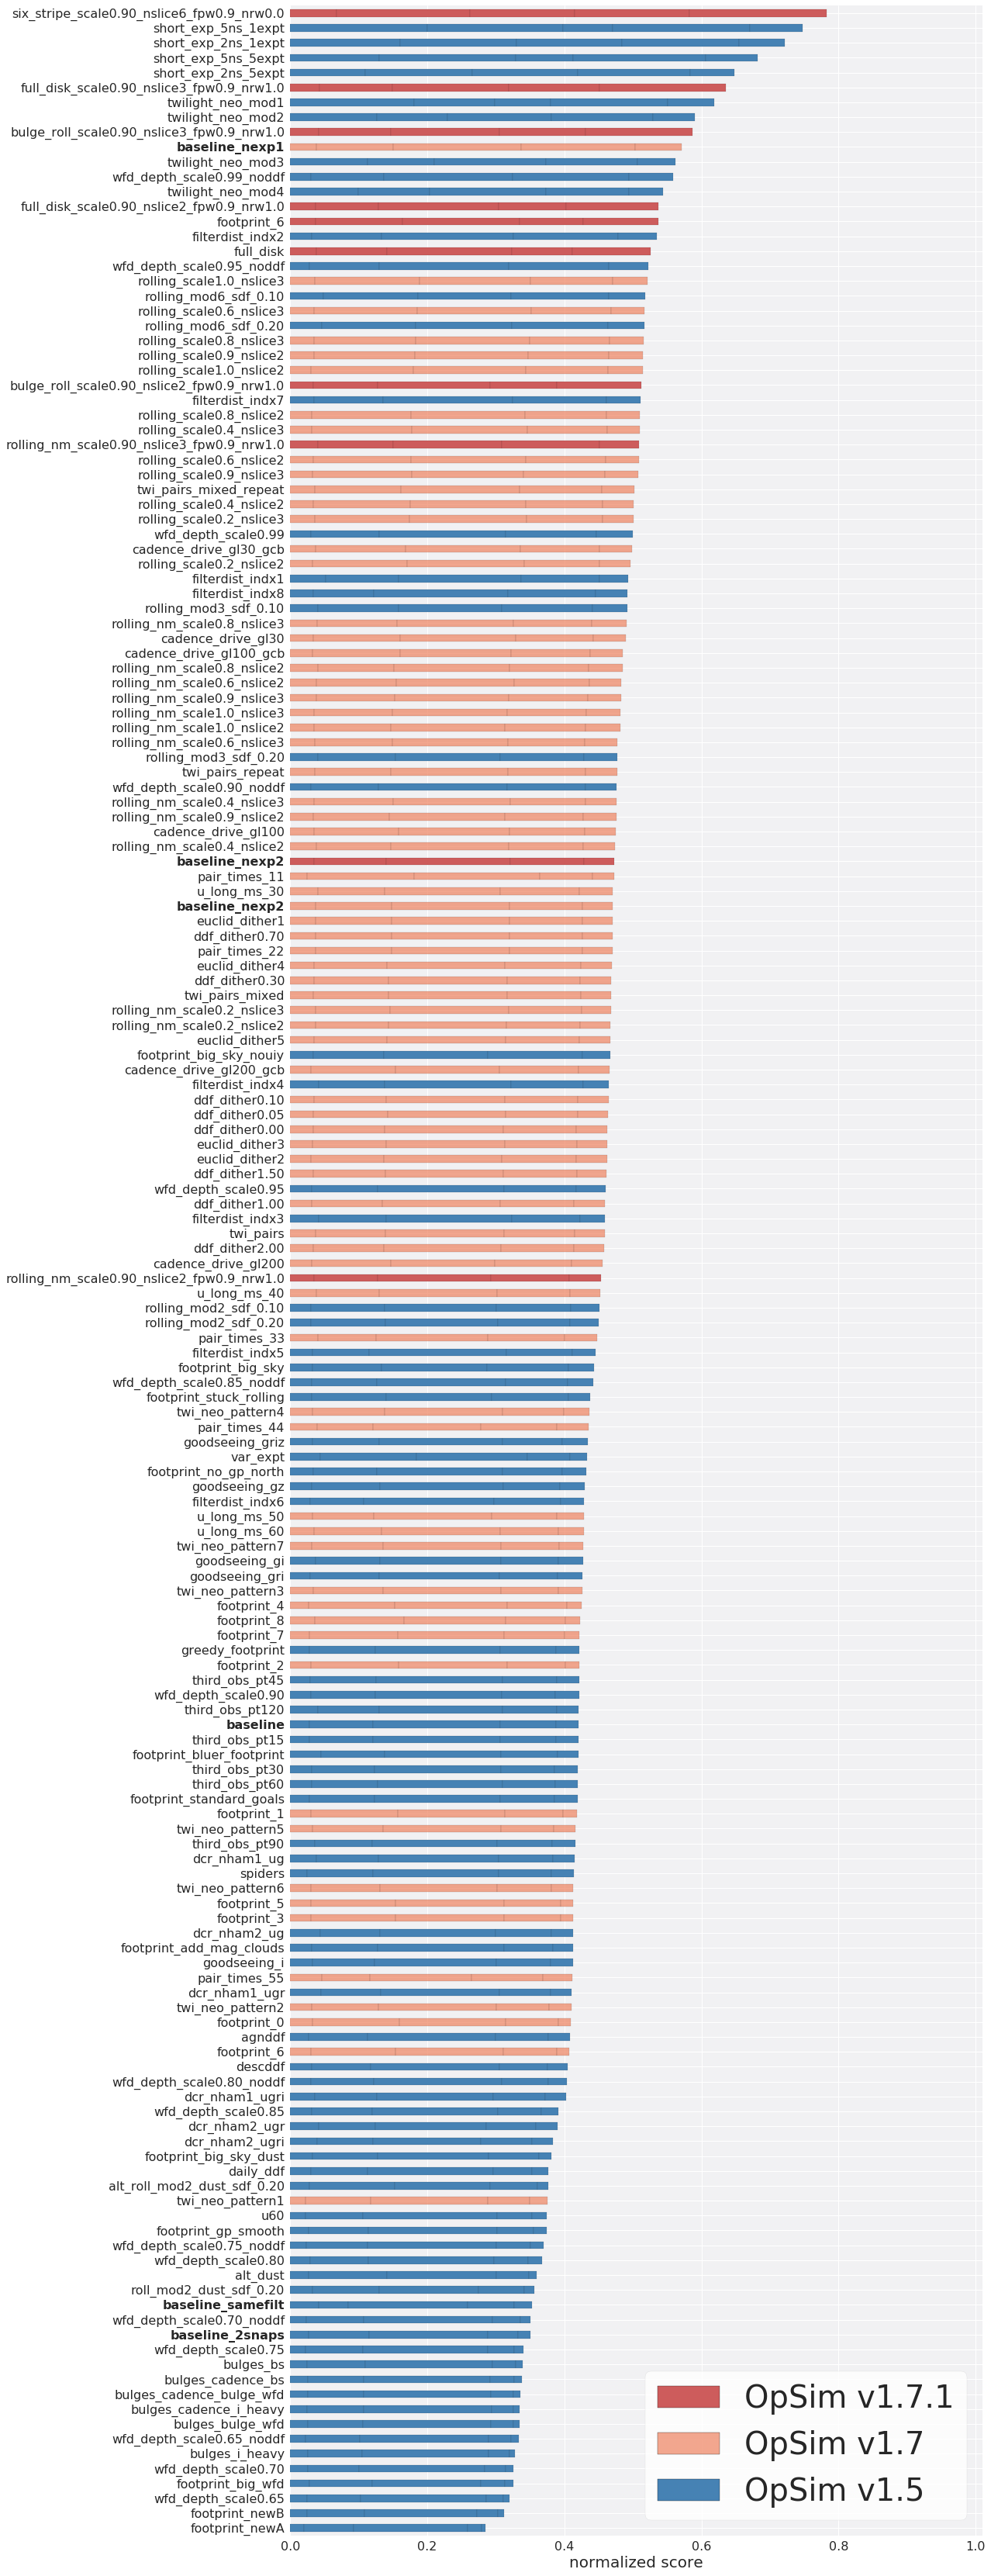

In [38]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_WFD_reduced.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_wfd_v1_5_v1_7_reduced.pdf', colormap=mymap ) 



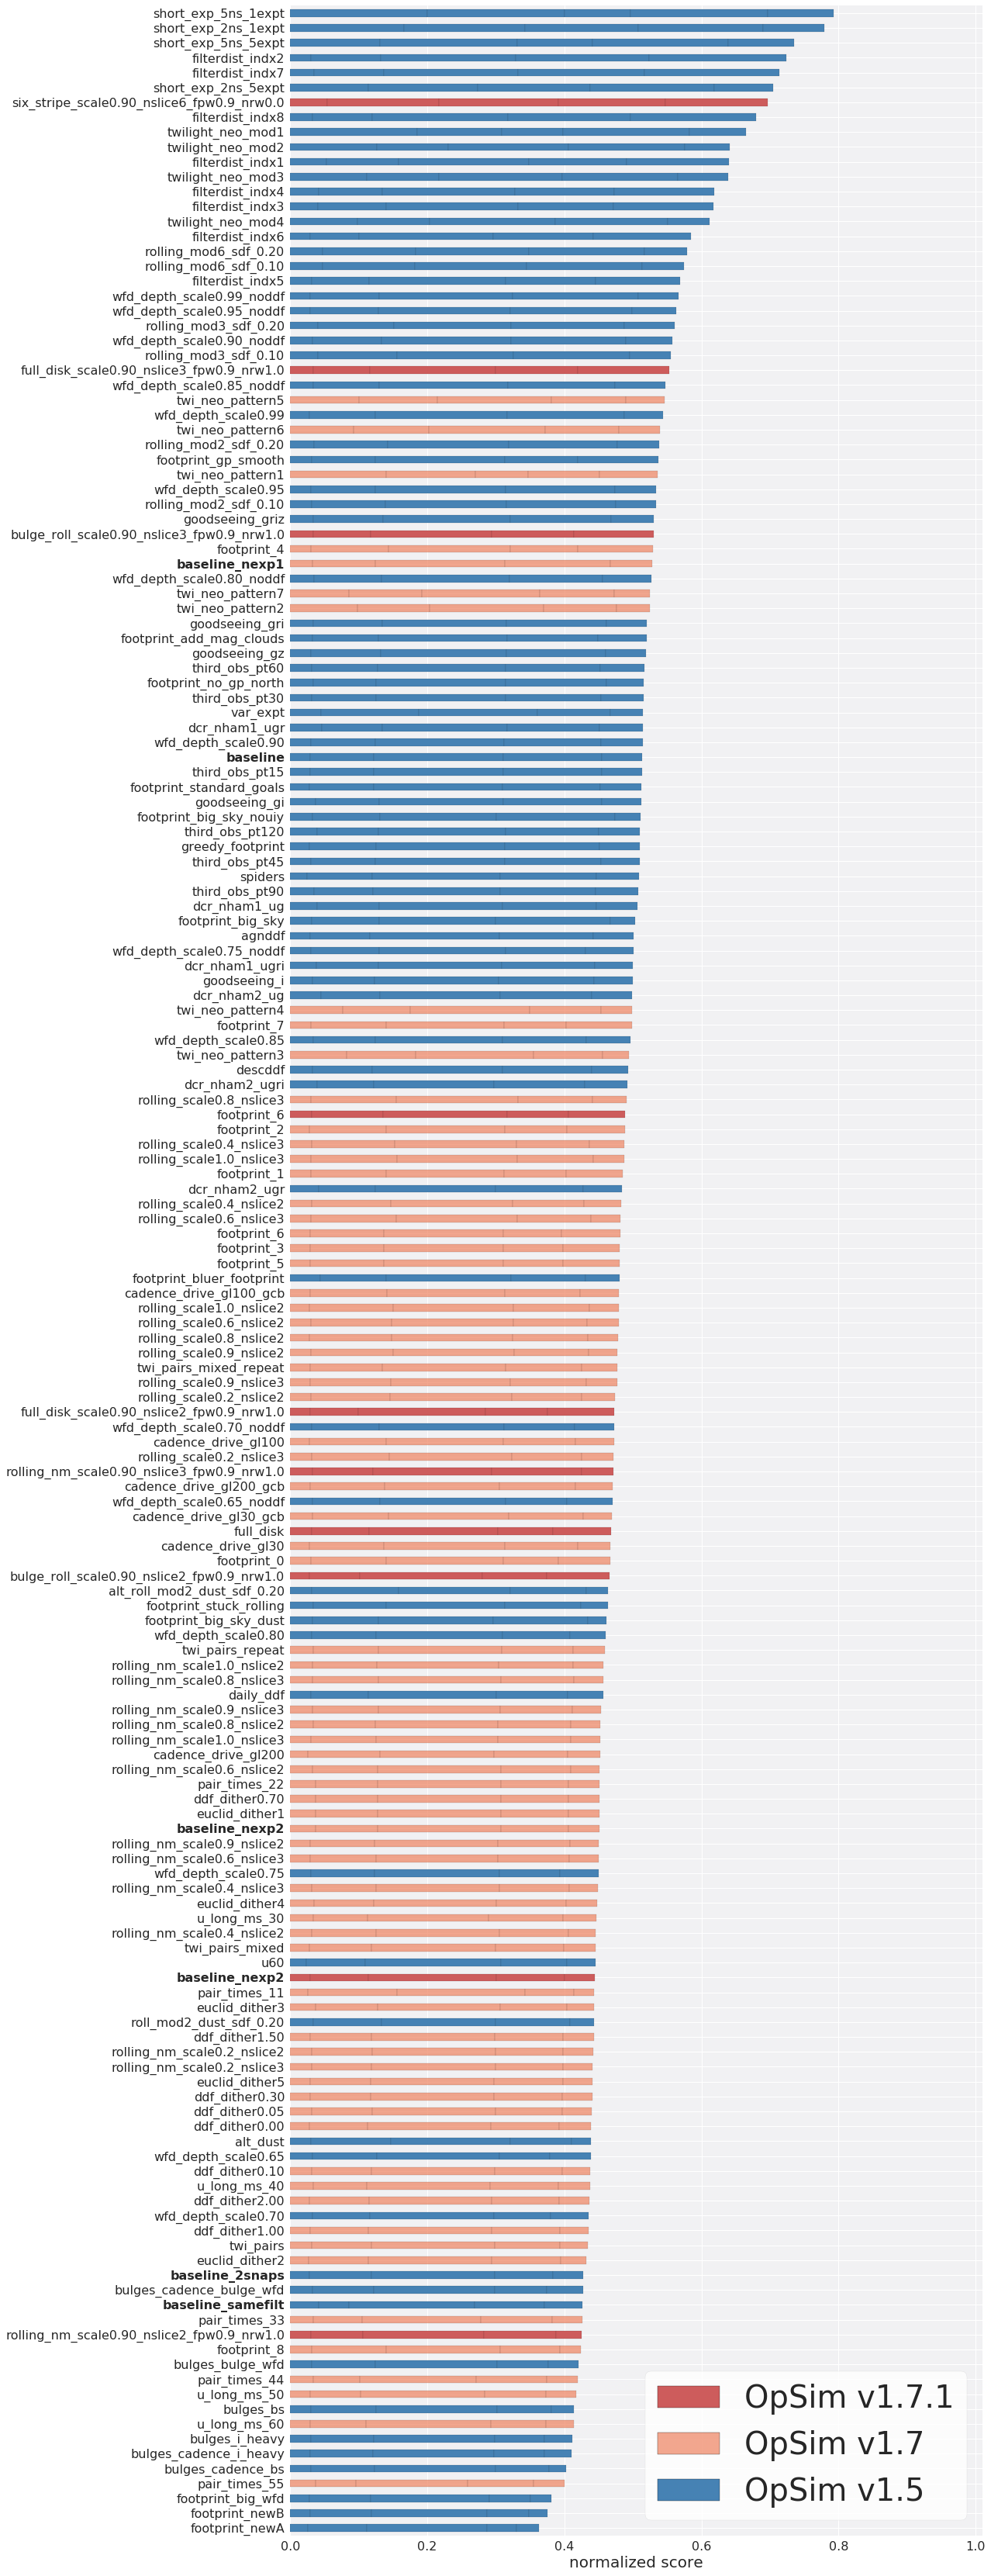

In [39]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_ALL.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv, cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7.pdf', colormap=mymap ) 



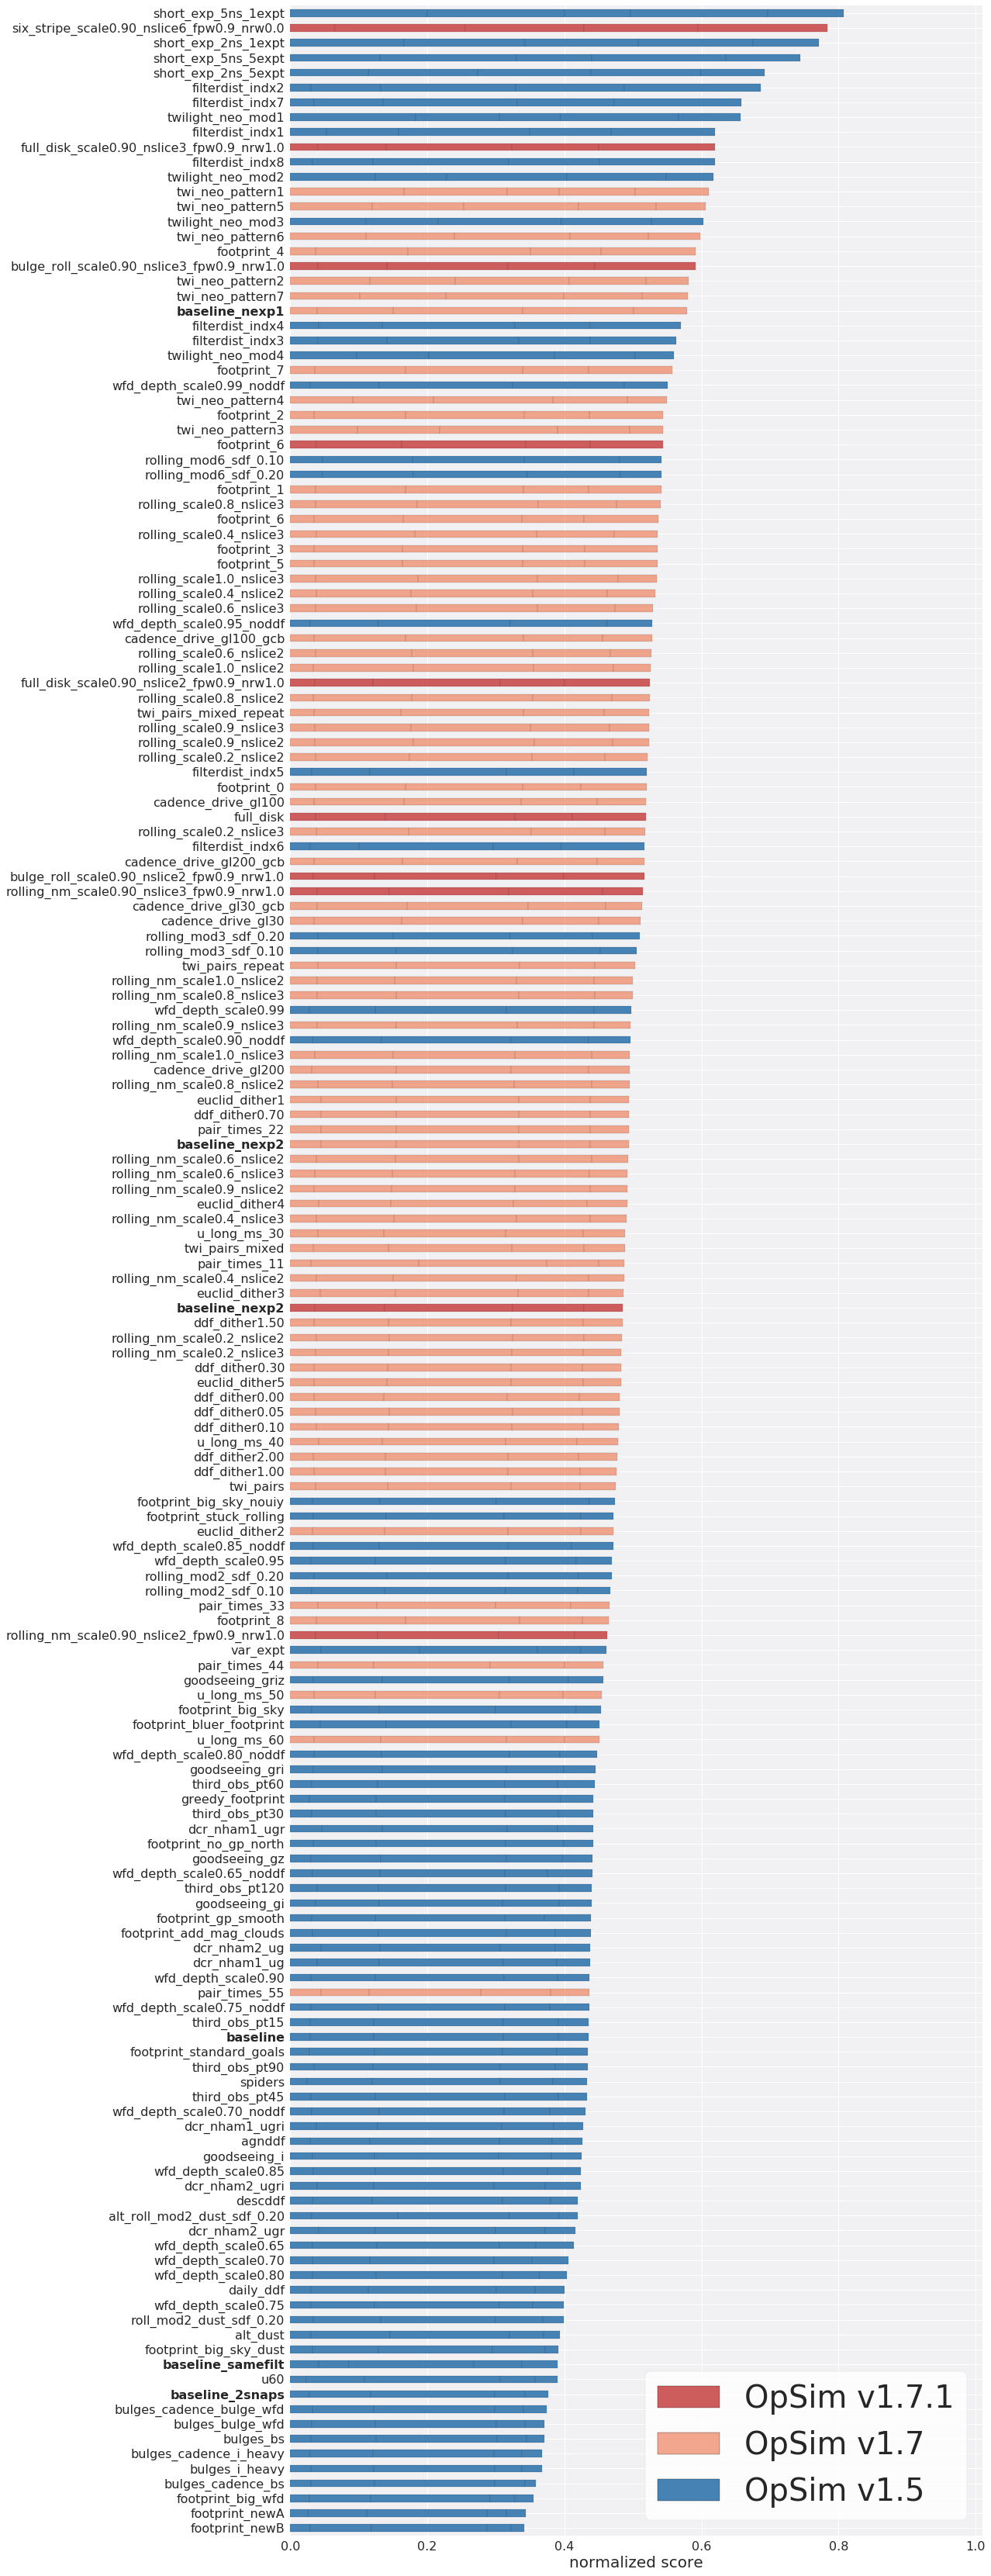

In [40]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_ALL_reduced.csv'

#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7_reduced.pdf', colormap=mymap ) 

